# Introducción

En esta práctica trabajaremos con datos de experimentos en los que se midió la actividad cerebral de sujetos mientras dormían dentro de un resonador nuclear. Esta técnica de medición se llama fMRI por sus siglas en inglés (Functional Magnetic Resonance Imaging) y permite obtener series temporales que reflejan de manera indirecta la actividad neuronal subyascente en áreas localizadas del cerebro.

En simultaneo a las mediciones de fMRI se tomaron registros de electroencefalografía (EEG) a partir de las cuales se pudo determinar las fases del sueño que atravesaron los sujetos durante el experimento.

Los datos que usaremos fueron tomados en el marco de un proyecto de investigación liderado por los Dres Enzo Tagliazucchi y Helmut Laufs en donde el objetivo principal era entender los cambios fisiológicos en el cerebro que acompañan las transiciones entre el sueño y la vigilia. Los resultados principales muestran cambios en la estructura de conectividad funcional (correlaciones) entre distintas áreas del cerebro. 

Nuestro objetivo aquí será construir un clasificador que sea capaz de identificar las diferentes etapas del sueño basado dichos cambios de la estructura de conectividad funcional.


### Referencias

Tagliazucchi, E., von Wegner, F., Morzelewski, A., Borisov, S., Jahnke, K., & Laufs, H. (2012). Automatic sleep staging using fMRI functional connectivity data. Neuroimage, 63(1), 63-72.

Tagliazucchi, E., & Laufs, H. (2014). Decoding wakefulness levels from typical fMRI resting-state data reveals reliable drifts between wakefulness and sleep. Neuron, 82(3), 695-708.

Haimovici, A., Tagliazucchi, E., Balenzuela, P., & Laufs, H. (2017). On wakefulness fluctuations as a source of BOLD functional connectivity dynamics. Scientific reports, 7(1), 5908.




In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sys
from itertools import groupby
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score,accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy.stats.stats import zscore
from scipy.spatial.distance import squareform, pdist


## Los datos


### Series temporales 

Vamos a trabajar con datos de 58 sujetos que permanecieron 52 minutos cada uno dentro del resonador y durante los cuales experimentaron transiciones de sueño/vigilia. Las mediciones registradas con el resonador consisten en series temporales correspondientes a la actividad cerebral (señal BOLD) de diferentes regiones del cerebro. Trabajaremos aquí con una representación de grano grueso del cerebro, en la cual el mismo fue parcelado en 116 regiones corticales y sub-corticales. 

El archivo 'ts.csv' contiene las series temporales de los 58 sujetos concatenadas. Cada columna del dataset corresponde a una región. Las mediciones duraron 52 minutos para cada sujeto, y la resolución temporal de la señal BOLD en este experimento fue de 2.08 segundos. De manera que para cada sujeto se tienen series temporales de 52 x 60/2.08= 1500 puntos. Al estar concatenados los sujetos, el dataset total tiene dimensiones 87000 x 116.

### Hipnogramas

El archivo 'Hypnograms.csv' contiene en cada columna el hipnograma de un sujeto, obtenido a partir del análisis de registros en simultáneo con EEG.

El código de los estados en el hipnograma es el siguiente: 

0: vigilia (wake)

-2, -3, -4: etapas de sueño no REM, que llamaremos N1, N2 y N3 respectivamente.


In [3]:
# Levantamos los datos

time_series_df=pd.read_csv('ts.csv.zip',header=None)
hypnograms_df=pd.read_csv('Hypnograms.csv',header=None)

N_regions=116 # Número de regiones del cerebro
N_volumes=1500 # Largo de las series temporales
N_subjects=58  # Número de sujetos



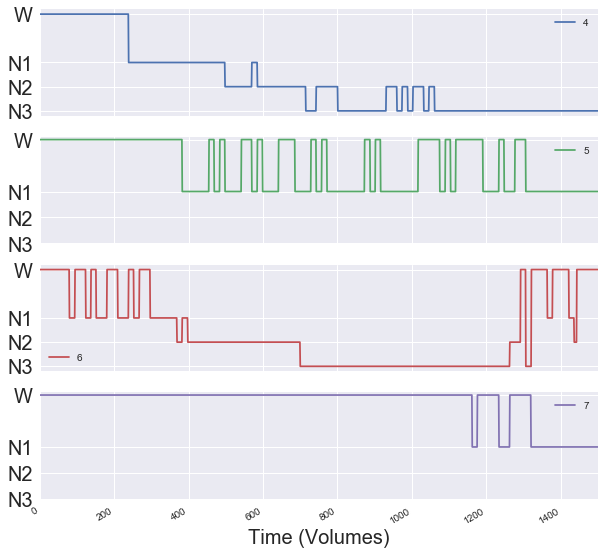

In [4]:
# Miremos algunos hipnogramas

axs=hypnograms_df.iloc[:,[4,5,6,7]].plot(subplots=True,figsize=(10,10),yticks=(0,-2,-3,-4),sharex=True)
for ax in axs:
    ax.set_yticklabels(('W','N1','N2','N3'),fontsize=20)
ax.set_xlabel('Time (Volumes)',fontsize=20)
plt.show()


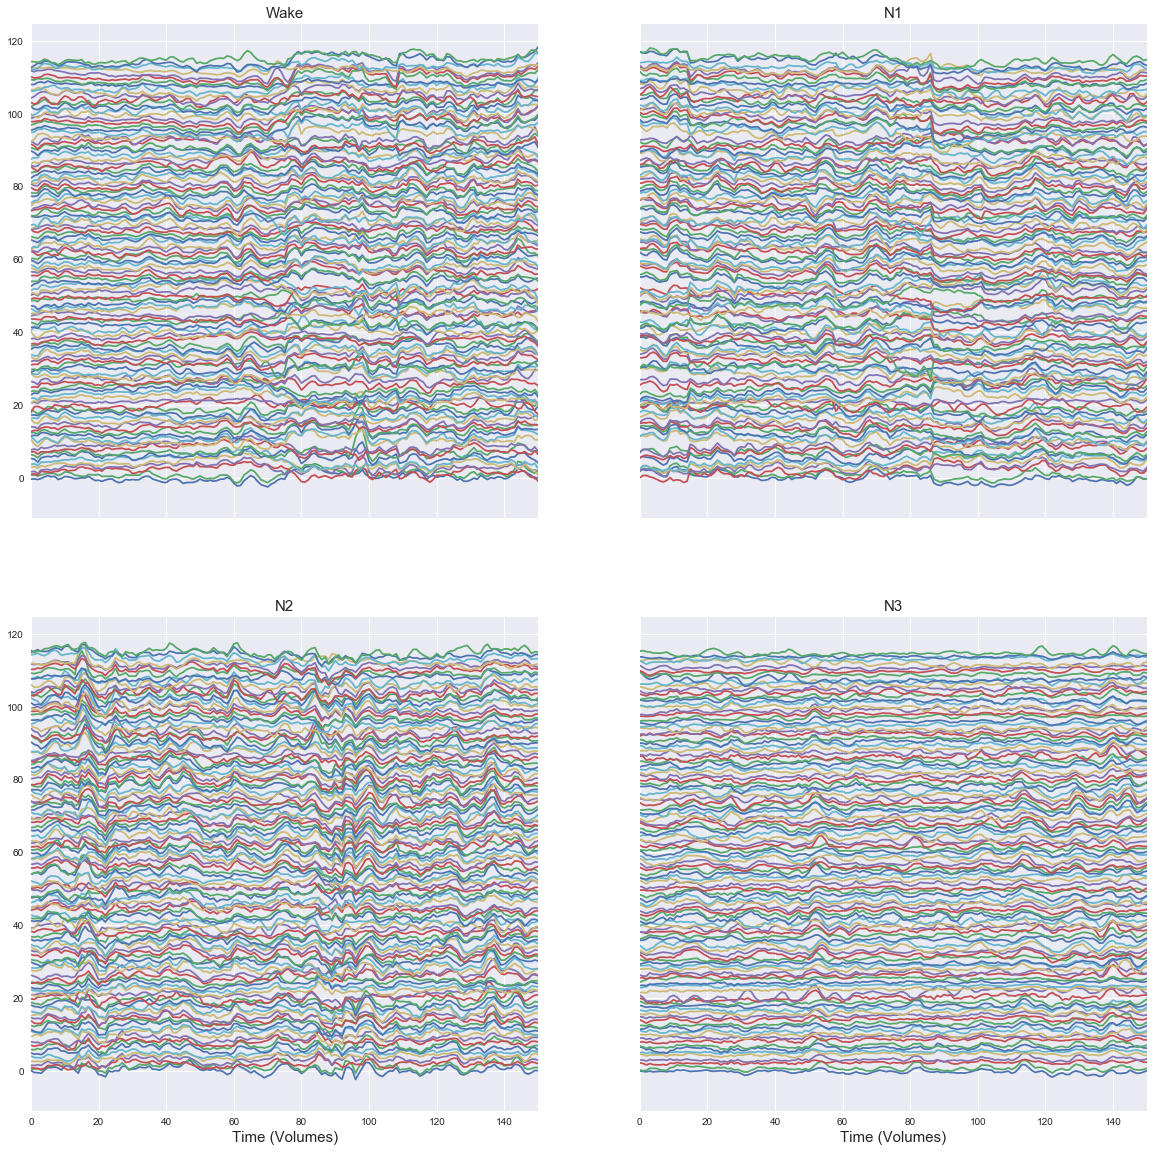

In [5]:
# Miremos algunas series temporales en diferentes etapas del sueño

subject=6
ts=time_series_df.iloc[subject*N_volumes:(subject+1)*N_volumes] # Seleccionamos las series temporales de un sujeto
h=hypnograms_df[subject];

n_points=150

sleep_state=0

fig,axs=plt.subplots(2,2,sharex=True,sharey=True,figsize=(20,20))

ts0=ts.iloc[h.values==sleep_state]
ts0.index=np.arange(np.sum(h==sleep_state))
offset=np.ones(ts0.shape)
for i in range(ts0.shape[1]):
    offset[:,i]=offset[:,i]*i
ts0=ts0+offset

ts0.plot(legend=False,ax=axs[0,0])
plt.xlim([0,n_points])
axs[0,0].set_title('Wake',fontsize=15)

sleep_state=-2

ts0=ts.iloc[h.values==sleep_state]
ts0.index=np.arange(np.sum(h==sleep_state))
offset=np.ones(ts0.shape)
for i in range(ts0.shape[1]):
    offset[:,i]=offset[:,i]*i
ts0=ts0+offset
ts0.plot(legend=False,ax=axs[0,1])
plt.xlim([0,n_points])
axs[0,1].set_title('N1',fontsize=15)
#plt.show()

sleep_state=-3
ts0=ts.iloc[h.values==sleep_state]
ts0.index=np.arange(np.sum(h==sleep_state))
offset=np.ones(ts0.shape)
for i in range(ts0.shape[1]):
    offset[:,i]=offset[:,i]*i
ts0=ts0+offset
ts0.plot(legend=False,ax=axs[1,0])
plt.xlim([0,n_points])
axs[1,0].set_title('N2',fontsize=15)
axs[1,0].set_xlabel('Time (Volumes)',fontsize=15)
#plt.show()

sleep_state=-4
ts0=ts.iloc[h.values==sleep_state]
ts0.index=np.arange(np.sum(h==sleep_state))
offset=np.ones(ts0.shape)
for i in range(ts0.shape[1]):
    offset[:,i]=offset[:,i]*i
ts0=ts0+offset
ts0.plot(legend=False,ax=axs[1,1])
plt.xlim([0,n_points])
axs[1,1].set_title('N3',fontsize=15)
axs[1,1].set_xlabel('Time (Volumes)',fontsize=15)
plt.show()


#### Para todo lo que sigue será más cómodo renombrar los estados de sueño según:

0: Wake

1: N1

2: N2

3: N3

In [6]:
# Renumeremos las etapas de sueño por comodidad según: 0=W, 1=N1, 2=N2, 3=N3
hypnograms_df[hypnograms_df==-2]=1;
hypnograms_df[hypnograms_df==-3]=2;
hypnograms_df[hypnograms_df==-4]=3;


### Veamos cómo cambia la probabilidad de estar despierto o en las diferentes fases del sueño, a lo largo del experimento

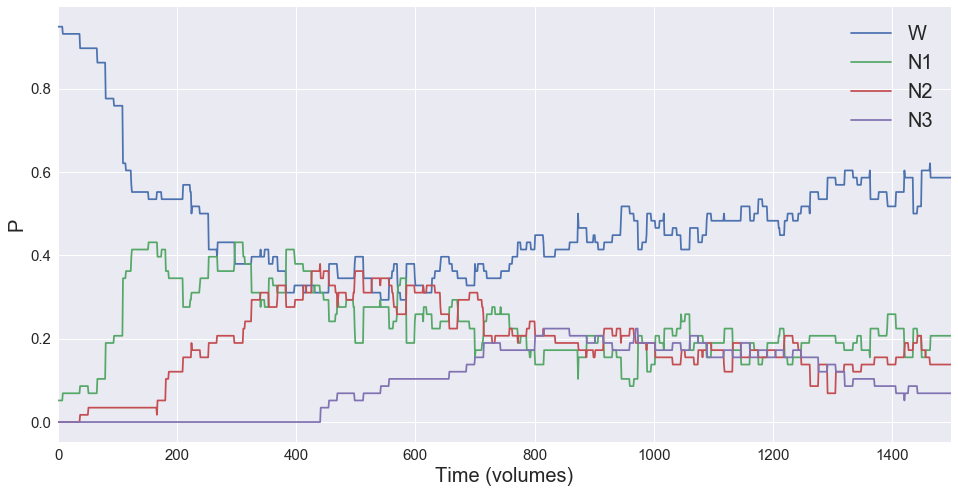

In [7]:
fig=plt.figure(figsize=(16,8))
(hypnograms_df==0).mean(axis=1).plot()
(hypnograms_df==1).mean(axis=1).plot()
(hypnograms_df==2).mean(axis=1).plot()
(hypnograms_df==3).mean(axis=1).plot()
time_axis=np.arange(N_volumes)*2.08/60
plt.legend(('W','N1','N2','N3'),fontsize=20)
plt.xlabel('Time (volumes)',fontsize=20)
plt.ylabel('P',fontsize=20)
ax = plt.gca()
ax.tick_params(labelsize=15)
plt.show()



### Veamos cómo está compuesto el dataset: cuán frecuentemente se observó cada estado de sueño y la variabilidad entre sujetos

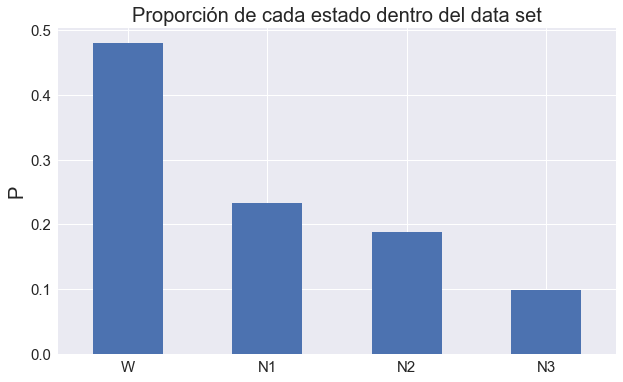

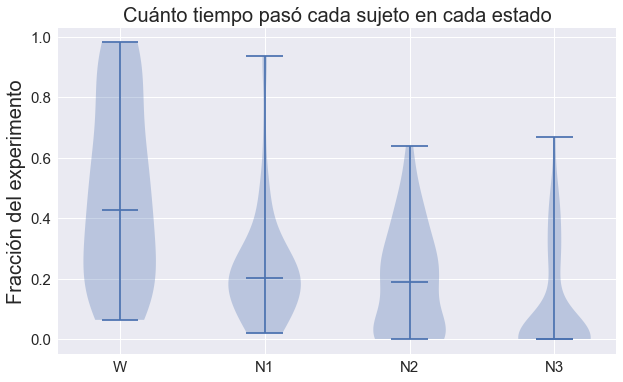

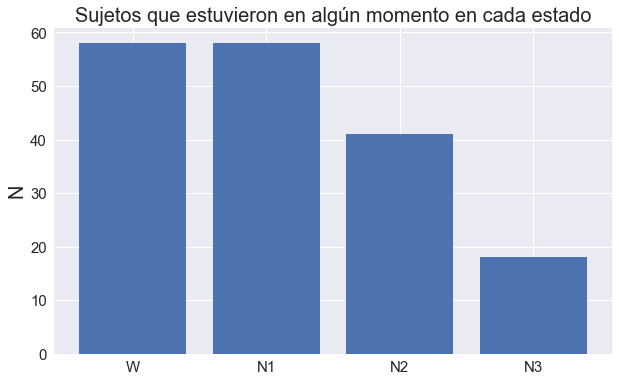

In [8]:
plt.figure(figsize=(10,6))
pd.value_counts(hypnograms_df.values.reshape((N_subjects*N_volumes,1)).squeeze(),normalize=True).plot.bar(rot=0)
plt.xticks(np.arange(0,4),('W','N1','N2','N3'),fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('P',fontsize=20)
plt.title('Proporción de cada estado dentro del data set',fontsize=20)
plt.show()


P_W=np.sum(hypnograms_df==0)/hypnograms_df.shape[0];
P_N1=np.sum(hypnograms_df==1)/hypnograms_df.shape[0];
P_N2=np.sum(hypnograms_df==2)/hypnograms_df.shape[0];
P_N3=np.sum(hypnograms_df==3)/hypnograms_df.shape[0];

plt.figure(figsize=(10,6))
plt.violinplot([P_W,P_N1,P_N2,P_N3], showmeans=False, showextrema=True, showmedians=True)
plt.xticks(np.arange(1,5),('W','N1','N2','N3'),fontsize=15)
plt.yticks(fontsize=15)
plt.title('Cuánto tiempo pasó cada sujeto en cada estado',fontsize=20)
plt.ylabel('Fracción del experimento',fontsize=20)
plt.show()

n_W=np.sum(P_W!=0)
n_N1=np.sum(P_N1!=0)
n_N2=np.sum(P_N2!=0)
n_N3=np.sum(P_N3!=0)

plt.figure(figsize=(10,6))
plt.bar(np.arange(4),np.array([n_W,n_N1,n_N2,n_N3]))
plt.xticks(np.arange(4),('W','N1','N2','N3'),fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('N',fontsize=20)
plt.title('Sujetos que estuvieron en algún momento en cada estado',fontsize=20)
plt.show()


## Estructura de correlaciones en las diferentes etapas de sueño

Miremos la matriz de CF entre todos los pares de regiones (116x116) para ver qué diferencias hay entre las distintas etapas de sueño y vigilia.

Para ello calculemos la matriz de correlaciones dentro de cada estado para cada sujeto y luego las promediamos.

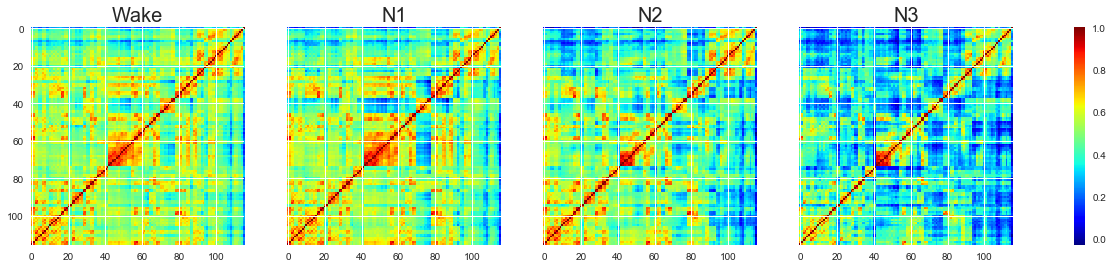

In [9]:
# Vamos a tomar para cada sujeto los momentos en los cuales estuvo en cada estado y calcular la matriz de correlacion lineal

C_W=np.zeros([N_regions,N_regions]) 
C_N1=np.zeros([N_regions,N_regions])
C_N2=np.zeros([N_regions,N_regions])
C_N3=np.zeros([N_regions,N_regions])

n_W=0
n_N1=0
n_N2=0
n_N3=0

for i in range(N_subjects):
    ts=time_series_df.iloc[i*N_volumes:(i+1)*N_volumes] # Series temporales del sujeto i-ésimo            
    if (hypnograms_df[i]==0).any(): # Si estuvo despierto en algún momento
        n_W+=1
        c1=ts.iloc[(hypnograms_df[i]==0).values].corr()
        C_W+=c1.values
    if (hypnograms_df[i]==1).any(): # Si pasó por la fase N1
        n_N1+=1
        c1=ts.iloc[(hypnograms_df[i]==1).values].corr()
        C_N1+=c1.values
    if (hypnograms_df[i]==2).any(): # Si pasó por la fase N2
        n_N2+=1
        c1=ts.iloc[(hypnograms_df[i]==2).values].corr()
        C_N2+=c1.values
    if (hypnograms_df[i]==3).any(): # Si pasó por la fase N3
        n_N3+=1
        c1=ts.iloc[(hypnograms_df[i]==3).values].corr()
        C_N3+=c1.values
        
C_W=C_W/n_W
C_N1=C_N1/n_N1
C_N2=C_N2/n_N2
C_N3=C_N3/n_N3

min_corr=np.min([np.min(C_W),np.min(C_N1),np.min(C_N2),np.min(C_N3)]) # Ploteamos las matrices en la misma escala
f, axs = plt.subplots(1, 4,figsize=(22,4),sharex=True,sharey=True)
axs[0].imshow(np.flipud(C_W),cmap='jet',interpolation='none' ,aspect="auto",clim=(min_corr,1))
axs[0].set_title('Wake',fontsize=20)

axs[1].imshow(np.flipud(C_N1),cmap='jet',interpolation='none',aspect="auto",clim=(min_corr,1))
axs[1].set_title('N1',fontsize=20)

axs[2].imshow(np.flipud(C_N2),cmap='jet',interpolation='none',aspect="auto",clim=(min_corr,1))
axs[2].set_title('N2',fontsize=20)

im=axs[3].imshow(np.flipud(C_N3),cmap='jet',interpolation='none',aspect="auto",clim=(min_corr,1))
axs[3].set_title('N3',fontsize=20)
f.colorbar(im, ax=axs.ravel().tolist())
plt.show()

# Clasificador de estados de sueño

Las diferencias que se observan en las matrices de conectividad funcional (CF) son auspiciosas: deberíamos poder detectarlas con un clasificador para identificar los estados de sueño.

Como la idea es poder captar las fluctuaciones entre la vigilia y las diferentes fases del sueño, tendremos que calcular la CF en ventanas de tiempo cortas.

Para entrenar el clasificador, nos convendrá armar un data set de entrenamiento en el cual las matrices de CF correspondan a estados de sueño/vigilia puros (es decir, no tomar ventanas temporales que agarren transiciones).

El ancho de la ventana temporal es un parámetro que tendremos que optimizar: mientras más ancha la ventana, menos ruidosas serán las matrices de CF, pero a la vez tendremos menos datos para entrenar.

### Test set
Antes de empezar a entrenar, separemos un grupo de sujetos que hayan experimentado todas las fases de sueño para usar como test set de nuestro clasificador. Como vimos más arriba, sólo 18 sujetos pasaron por la fase N3. Separemos 9 de esos sujetos para usar como test set y sumemos 4 sujetos más elegidos al azar. 

Para obtener resultados generalizables a situaciones en las que no se cuenta con el co-registro de EEG (hipnogramas) debemos construir las matrices de CF del test set sin usar esta información. Calcularemos entonces las matrices de CF usando sliding windows de manera que algunas de ellas comprenderán las transiciones entre estados.


In [10]:
# Elegimos 9 sujetos que hayan experimentado todas las etapas de sueño. (Sólo 18 lo hicieron)
# Separamos los datos para training y testing

np.random.seed(0)
Subjects=list(np.arange(58))
Subjects_with_full_cycle=np.sum(hypnograms_df==3).nonzero()[0]
Test_subjects=np.random.choice(Subjects_with_full_cycle,9,replace=False)
Test_subjects=list(Test_subjects)

for s in Subjects_with_full_cycle:
    Subjects.remove(s)

for s in list(np.random.choice(Subjects,4,replace=False)):
    Test_subjects.append(s)
Test_subjects.sort()    

Train_subjects=list(np.arange(0,58))
for s in Test_subjects:
    Train_subjects.remove(s)
      

print('Train Subjects')    
print(Train_subjects)
print()
print('Test Subjects')
print(Test_subjects)

Train Subjects
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 15, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 36, 37, 39, 40, 41, 42, 44, 45, 46, 47, 48, 50, 51, 54, 55, 57]

Test Subjects
[6, 14, 16, 17, 23, 34, 35, 38, 43, 49, 52, 53, 56]


In [11]:
# NUMERO DE EPOCAS NO SOLAPADAS EN EL DATA SET TOTAL

def Number_of_non_overlapping_epochs(hypnograms_df,Subjects):

    volumes = range(hypnograms_df.shape[0])
    Wake_periods_lengths=[]
    N1_periods_lengths=[]
    N2_periods_lengths=[]
    N3_periods_lengths=[]

    for subject in Subjects:    
        for group in groupby(iter(volumes), lambda x: hypnograms_df[subject].iloc[x]):        
            if group[0]==0:
                Wake_periods_lengths.append(len(list(group[1])))
            elif group[0]==1:
                N1_periods_lengths.append(len(list(group[1])))
            elif group[0]==2:
                N2_periods_lengths.append(len(list(group[1])))
            elif group[0]==3:
                N3_periods_lengths.append(len(list(group[1])))

    # Numero de ventanas no solapadas de largo w, para w=[30,60,90,120]    
    Non_overlapping_periods=[[],[],[],[]]
    Window_size=[30,60,90,120]
    
    for w in Window_size:
        n=int(np.sum(np.floor(np.array(Wake_periods_lengths)/w)))
        Non_overlapping_periods[0].append(n)

        n=int(np.sum(np.floor(np.array(N1_periods_lengths)/w)))
        Non_overlapping_periods[1].append(n)

        n=int(np.sum(np.floor(np.array(N2_periods_lengths)/w)))
        Non_overlapping_periods[2].append(n)

        n=int(np.sum(np.floor(np.array(N3_periods_lengths)/w)))
        Non_overlapping_periods[3].append(n)

    NOP=pd.DataFrame(Non_overlapping_periods)
    NOP.columns=['1min','2min','3min','4min']
    NOP.index=['W','N1','N2','N3']
    
    print()
    print(NOP)
    
    
##################################################

print('NUMERO DE ÉPOCAS USANDO VENTANAS NO SOLAPADAS')
print()
print()

print('EN TODO EL DATASET')
Number_of_non_overlapping_epochs(hypnograms_df,list(np.arange(58)))

print()
print()
print('EN NUESTRO TRAINING SET')
Number_of_non_overlapping_epochs(hypnograms_df,Train_subjects)

print()
print()
print('EN NUESTRO TEST SET')
Number_of_non_overlapping_epochs(hypnograms_df,Test_subjects)


NUMERO DE ÉPOCAS USANDO VENTANAS NO SOLAPADAS


EN TODO EL DATASET

    1min  2min  3min  4min
W   1225   565   354   243
N1   470   186   103    63
N2   452   197   114    74
N3   262   124    78    56


EN NUESTRO TRAINING SET

    1min  2min  3min  4min
W   1073   501   314   218
N1   381   153    91    55
N2   303   132    71    50
N3   142    67    42    29


EN NUESTRO TEST SET

    1min  2min  3min  4min
W    152    64    40    25
N1    89    33    12     8
N2   149    65    43    24
N3   120    57    36    27


### Funciones que calculan las matrices de CF:

In [12]:
# Definimos una funcion que compute las matrices de correlacion en ventanas temporales no solapadas de ancho w,
# para un subset de sujetos.

def matCorr_non_overlapping(time_series_df,hypnograms_df,Subjects,w):
    print('Calculando matrices de correlacion')
    start_time=time.time()
    
    mat_Corr=[]
    sleep_stage=[]    
    n_volumes=hypnograms_df.shape[0]

    for subject in Subjects:        
        for group in groupby(iter(range(n_volumes)), lambda x: hypnograms_df[subject].iloc[x]):                 
            period=list(group[1]) # Periodo de tiempo (indices) con una etapa de sueño sostenida
            n_epochs=int(np.floor(len(period)/w))
            for epoch in range(n_epochs):                
                c1=time_series_df.iloc[subject*1500+period[epoch*w:(epoch+1)*w]].corr()                            
                np.fill_diagonal(c1.values,0) # REPLACE THE DIAGONAL ELEMENTS BY 0
                mat_Corr.append(squareform(c1))# RESHAPES THE SYMMETRIC MATRIX INTO A 1-D VECTOR AND STORES IT IN mat_Corr
                sleep_stage.append(group[0]) # sleep stage                                    
    
    end_time=time.time()    
    print('Elapsed time:',np.around(end_time-start_time,decimals=2),' seg')
    
    return np.array(mat_Corr),np.array(sleep_stage)

#############################################################################################

def matCorr_sliding(time_series_df,hypnograms_df,Subjects,w):
    print('Computando matrices de correlacion en sliding windows. Esto puede llevar algunos minutos.')
    
    start_time=time.time()
    
    n_regions=time_series_df.shape[1]
    n_volumes=hypnograms_df.shape[0]
    n_epochs=(n_volumes-w)*len(Subjects) # Number of correlation matrices to be stored
        
    mat_Corr=np.zeros([n_epochs,int(n_regions*(n_regions-1)*0.5)],dtype=np.float32)
    sleep_stage_prob=np.zeros([n_epochs,4]) # Aquí guardaremos en qué proporción aparecen distintos estados de sueño dentro de la ventana temporal
        
    epoch=0
    for subject in Subjects:
        for t in range(n_volumes-w):                            
            c1=time_series_df.iloc[subject*n_volumes+t:subject*n_volumes+t+w].corr()
            np.fill_diagonal(c1.values,0) # quitamos los 1's de la diagonal para poder usar la funcion squareform, que extrae el triangulo superior de la matriz
            mat_Corr[epoch,:]=squareform(c1)                        
            VC=hypnograms_df[subject].iloc[t:t+w].value_counts() 
            sleep_stage_prob[epoch][VC.keys()]=VC.values
            epoch+=1
            
    
    sleep_stage_prob=normalize(sleep_stage_prob, axis=1, norm='l1')
    
    end_time=time.time()
    print('Elapsed time:',np.around(end_time-start_time,decimals=2),' seg')
                            
    sleep_stage=np.argmax(sleep_stage_prob, axis=1)
    
    Output={'matCorr':mat_Corr,'sleep_stage':sleep_stage,'sleep_stage_prob':sleep_stage_prob}
    
    return Output
    


### La siguiente función entrena un random forest y devuelve los resultados de la cross-validation

In [13]:
#############################################################################################

def train_random_forest(data,target,num_trees,n_folds,percentile,num_iter):
        
    print()
    print('Start training')    
    
    skf = StratifiedKFold(n_splits=n_folds,shuffle=True)                
    cv_target =[]
    cv_probas =[]
    cv_predictions=[]

    feature_imp=np.zeros((int(np.round(data.shape[1]*percentile/100)),num_iter* n_folds))

    test_indices=[]

    counter=-1

    start_time=time.time()

    for iteration in range(num_iter):
        print('Iteration:',iteration)
        for train_index, test_index in skf.split(data, target):
            counter+=1

            X_train, X_test = data[train_index], data[test_index]
            y_train, y_test = target[train_index], target[test_index]

            selector = SelectPercentile(f_classif, percentile=percentile) # apply feature selection (F-test) on the training data
            selector.fit(X_train, y_train)
            X_train_fs = selector.transform(X_train)
            X_test_fs = selector.transform(X_test)

            clf = RandomForestClassifier(n_estimators=num_trees) # create, train and predict the scores for the features in the test set
            clf = clf.fit(X_train_fs, y_train)
            preds = clf.predict(X_test_fs)
            probas = clf.predict_proba(X_test_fs)

            cv_target.append(y_test) # add the results across all the folds                
            cv_probas.append(probas)
            cv_predictions.append(preds)
            feature_imp[:,counter]=clf.feature_importances_                   

    cv_target=np.concatenate(cv_target,axis=0)
    cv_probas=np.concatenate( cv_probas, axis=0 )       
    cv_predictions=np.concatenate(cv_predictions,axis=0)

    end_time=time.time()

    print()
    print('Terminó el entrenamiento en ',np.round(end_time-start_time), 'segundos')
    print()
    
    return cv_target,cv_predictions,cv_probas

############################################################################################

In [14]:
# Definamos el input
w=90
data,target= matCorr_non_overlapping(time_series_df,hypnograms_df,Train_subjects,w)

num_trees=200 #number of trees in the random forest algorithm
n_folds=5 # number of folds for cross validation
percentile = 10 # this defines the percentile of features that we are going to use in the classification (top percentile%)
num_iter=5

cv_target,cv_predictions,cv_probas = train_random_forest(data,target,num_trees,n_folds,percentile,num_iter)


Calculando matrices de correlacion
Elapsed time: 2.13  seg

Start training
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4

Terminó el entrenamiento en  20.0 segundos



## Veamos cómo evaluar la performance del clasificador, teniendo en cuenta diferentes métricas

#### 1) Un buen lugar para empezar es ver el porcentaje de etiquetas correctamente identificadas (accuracy).

In [15]:
# Calculamos la accuracy
acc=accuracy_score(cv_target, cv_predictions, normalize=True)
print('Accuracy:',np.around(acc,decimals=3))


Accuracy: 0.836


#### 2) Veamos las curvas ROC para cada clase. Es decir separamos el problema en uno de clasificación binaria (one vs all) para cada clase y calculamos el TPR y FPR variando el threshold del clasificador. Idealmente, el área debajo de la curva TPR vs FPR debería ser cercano a 1.

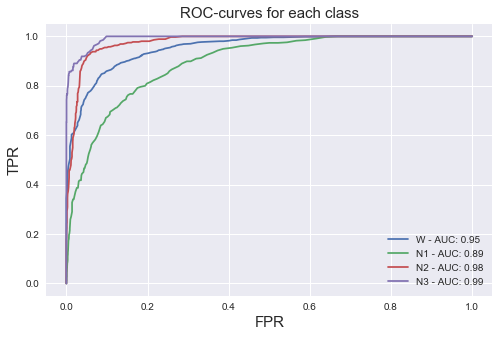

Mean AUC: 0.95


In [16]:
######################### EVALUACIÓN ONE VS ALL PARA CADA CLASE ##############################

area_under_curve=[]
fig=plt.figure(figsize=(8,5))
for t in np.unique(target): # for each class
    binary_targets=(cv_target==t)
    fpr, tpr, thresholds =roc_curve(binary_targets,cv_probas[:,int(t)])    
    plt.plot(fpr,tpr)
    area_under_curve.append( auc(fpr, tpr))    

plt.legend(('W - AUC: '+str(np.around(area_under_curve[0],decimals=2)),
            'N1 - AUC: '+str(np.around(area_under_curve[1],decimals=2)),
            'N2 - AUC: '+str(np.around(area_under_curve[2],decimals=2)),
            'N3 - AUC: '+str(np.around(area_under_curve[3],decimals=2))))         
plt.xlabel('FPR',fontsize=15)
plt.ylabel('TPR',fontsize=15)
plt.title('ROC-curves for each class',fontsize=15)
plt.show()

print('Mean AUC:',np.around(np.mean(area_under_curve),decimals=2))



#### 3) Veamos exactamente qué estamos clasificando, mirando la matriz de confusión. Idealmente debería verse diagonal.

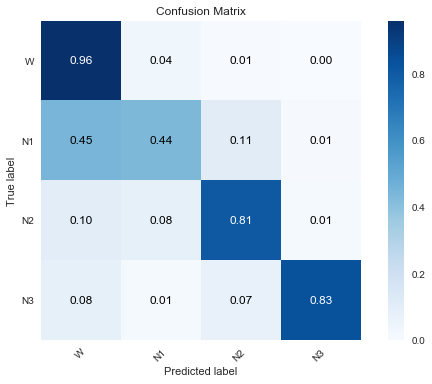

Mean diagonal: 0.76


In [17]:
def plot_confusion_matrix(y_true, y_pred,classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.grid(False)
    return ax

#######################################################################################

cm = confusion_matrix(cv_target,cv_predictions).astype(float)
plot_confusion_matrix(cv_target, cv_predictions, classes=np.array(['W','N1','N2','N3']),title='Confusion Matrix',normalize=True)
plt.show()

cm = confusion_matrix(cv_target,cv_predictions).astype(float)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Mean diagonal:',np.around(cm.diagonal().mean(),decimals=2))



#### 4) Miremos las curvas de precision vs recall, que son más informativas que las curvas ROC para muestras desbalanceadas. Y veamos el F-score de cada clase.

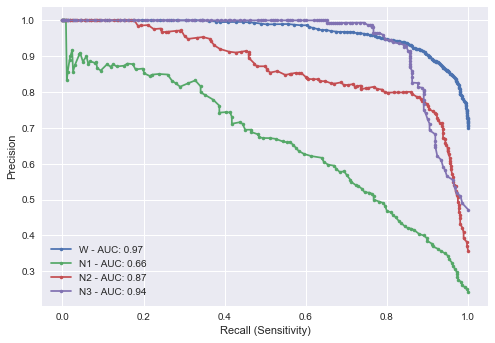

###################

Mean AUC: 0.86

###################

F1 score para cada clase:

W: 0.9
N1: 0.54
N2: 0.8
N3: 0.89


mean F1 score: 0.78



In [18]:
area_under_curve=[]
for t in np.unique(target): # for each class
    binary_targets=(cv_target==t)
    precision, recall, thresholds = precision_recall_curve(binary_targets, cv_probas[:,int(t)])          
    area_under_curve.append( auc(recall, precision))    
    plt.plot(recall, precision, marker='.')

plt.legend(('W - AUC: '+str(np.around(area_under_curve[0],decimals=2)),
            'N1 - AUC: '+str(np.around(area_under_curve[1],decimals=2)),
            'N2 - AUC: '+str(np.around(area_under_curve[2],decimals=2)),
            'N3 - AUC: '+str(np.around(area_under_curve[3],decimals=2))))                                                

plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.show()

print('###################')
print()
print('Mean AUC:',np.around(np.array(area_under_curve).mean(),decimals=2))
print()
print('###################')
print()

f1_classes = f1_score(cv_target, cv_predictions, average=None)            
f1_averaged = f1_classes.mean()

f1_classes=np.around(f1_classes,decimals=2)

print('F1 score para cada clase:')
print()
print('W:',f1_classes[0])
print('N1:',f1_classes[1])
print('N2:',f1_classes[2])
print('N3:',f1_classes[3])
print()
print()

print('mean F1 score:', np.around(f1_averaged,decimals=2)  )
print()




In [19]:
def bateria_de_metricas(cv_target,cv_predictions,cv_probas,show_outputs):
            
    ############################## ACCURACY ###################################

    # Calculamos la accuracy
    acc=accuracy_score(cv_target, cv_predictions, normalize=True)    
    if show_outputs:
        print('Accuracy:',np.around(acc,decimals=2))

    ######################### ROC CURVES - EVALUACIÓN ONE VS ALL PARA CADA CLASE ##############################
    area_under_curve=[]
    fig=plt.figure(figsize=(8,5))
    for t in np.unique(target): # for each class
        binary_targets=(cv_target==t)
        fpr, tpr, thresholds =roc_curve(binary_targets,cv_probas[:,int(t)])    
        area_under_curve.append( auc(fpr, tpr))    
        if show_outputs:
            plt.plot(fpr,tpr)

    if show_outputs:
        plt.legend(('W - AUC: '+str(np.around(area_under_curve[0],decimals=2)),
                    'N1 - AUC: '+str(np.around(area_under_curve[1],decimals=2)),
                    'N2 - AUC: '+str(np.around(area_under_curve[2],decimals=2)),
                    'N3 - AUC: '+str(np.around(area_under_curve[3],decimals=2))))         
        plt.xlabel('FPR',fontsize=15)
        plt.ylabel('TPR',fontsize=15)
        plt.title('ROC-curves for each class',fontsize=15)
        plt.show()

        print('Mean AUC:',np.around(np.mean(area_under_curve),decimals=2))
    
    auc_ROC=np.around(np.mean(area_under_curve),decimals=2)
        
        
    #######################################################################################
    
    
    cm = confusion_matrix(cv_target,cv_predictions).astype(float)
    cm = confusion_matrix(cv_target,cv_predictions).astype(float)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    if show_outputs:
        plot_confusion_matrix(cv_target, cv_predictions, classes=np.array(['W','N1','N2','N3']),title='Confusion Matrix',normalize=True)
        plt.show()
        print('Mean diagonal:',np.around(cm.diagonal().mean(),decimals=2))

    mean_diagonal_cm=np.around(cm.diagonal().mean(),decimals=2)
    
    #######################################################################################

    area_under_curve=[]
    for t in np.unique(target): # for each class
        binary_targets=(cv_target==t)
        precision, recall, thresholds = precision_recall_curve(binary_targets, cv_probas[:,int(t)])          
        area_under_curve.append( auc(recall, precision))  
        if show_outputs:
            plt.plot(recall, precision, marker='.')    
            
    f1_classes = f1_score(cv_target, cv_predictions, average=None)            
    mean_F1 = f1_classes.mean()    
    auc_PR = np.array(area_under_curve).mean()
    
    
    if show_outputs:
        plt.legend(('W - AUC: '+str(np.around(area_under_curve[0],decimals=2)),
                    'N1 - AUC: '+str(np.around(area_under_curve[1],decimals=2)),
                    'N2 - AUC: '+str(np.around(area_under_curve[2],decimals=2)),
                    'N3 - AUC: '+str(np.around(area_under_curve[3],decimals=2))))                                                

        plt.xlabel('Recall (Sensitivity)')
        plt.ylabel('Precision')
        plt.show()

        print('###################')
        print()
        print('Mean AUC:',np.around(auc_PR, decimals=2))
        print()
        print('###################')
        print()


        print('F1 score para cada clase:')
        print()
        print('W:',np.around(f1_classes[0],decimals=2))
        print('N1:',np.around(f1_classes[1],decimals=2))
        print('N2:',np.around(f1_classes[2],decimals=2))
        print('N3:',np.around(f1_classes[3],decimals=2))
        print()
        print()

        print('mean F1 score:',np.around(mean_F1,decimals=2)       )
    
    Output={'Accuracy':acc,'auc_ROC':auc_ROC,'CM_mean_diagonal':mean_diagonal_cm,
            'Confusion_Matrix':cm,'auc_PR':auc_PR,'F1_per_class':f1_classes,'Mean_F1':mean_F1}
    return Output

######################################################################


### Con qué deberíamos comparar estas métricas? Un test interesante (pero condescendiente) sería entrenar el mismo clasificador randomizando las etiquetas.

In [20]:
target_sh = np.random.permutation(target)  # !!!! label shuffling !!
cv_target_sh,cv_predictions_sh,cv_probas_sh = train_random_forest(data,target_sh,num_trees,n_folds,percentile,num_iter)



Start training
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4

Terminó el entrenamiento en  28.0 segundos



Accuracy: 0.59


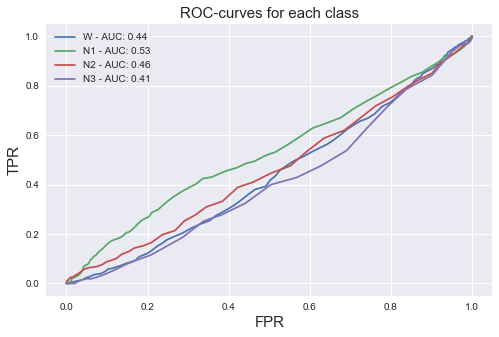

Mean AUC: 0.46


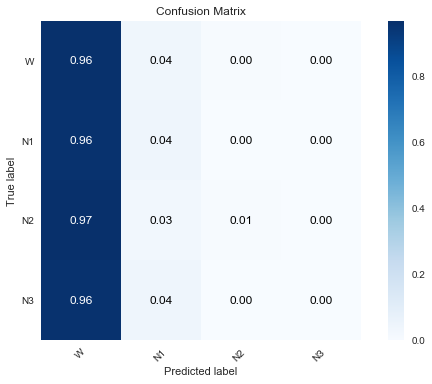

Mean diagonal: 0.25


/home/ahaimovici/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


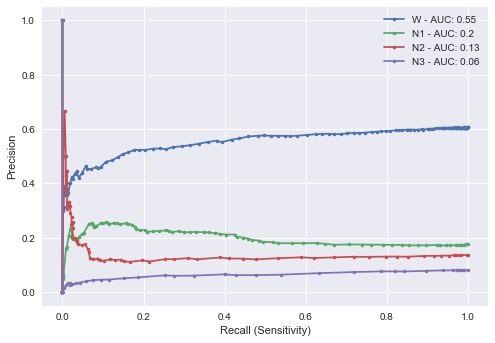

###################

Mean AUC: 0.24

###################

F1 score para cada clase:

W: 0.74
N1: 0.07
N2: 0.01
N3: 0.0


mean F1 score: 0.21


In [21]:
Metrics = bateria_de_metricas(cv_target_sh,cv_predictions_sh,cv_probas_sh,show_outputs=True)


In [22]:
# VEAMOS CUÁNTO IMPORTA EL TAMAÑO DE LAS VENTANAS TEMPORALES

Window_size=[50,100,150,200]
num_trees=200 #number of trees in the random forest algorithm
n_folds=5 # number of folds for cross validation
percentile = 10 # this defines the percentile of features that we are going to use in the classification (top percentile%)
num_iter=5

ACC=[]
AUC_ROC=[]
AUC_PR=[]
CM_diag=[]
F1=[]

start_time=time.time()
for w in Window_size:
    
    print('########################')
    print('WINDOW SIZE',w)
    print('########################')
        
    data,target= matCorr_non_overlapping(time_series_df,hypnograms_df,Train_subjects,w)
    cv_target,cv_predictions,cv_probas = train_random_forest(data,target,num_trees,n_folds,percentile,num_iter)
    Metricas = bateria_de_metricas(cv_target,cv_predictions,cv_probas,show_outputs=False)
    ACC.append(Metricas['Accuracy'])  
    AUC_ROC.append(Metricas['auc_ROC'])
    CM_diag.append(Metricas['CM_mean_diagonal'])
    AUC_PR.append(Metricas['auc_PR'])
    F1.append(Metricas['Mean_F1'])
    
end_time=time.time()    
print('Total Elapsed Time:',np.around((end_time- start_time)/60,decimals=2 ),' min' )



########################
WINDOW SIZE 50
########################
Calculando matrices de correlacion
Elapsed time: 2.68  seg

Start training
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4

Terminó el entrenamiento en  49.0 segundos

########################
WINDOW SIZE 100
########################
Calculando matrices de correlacion
Elapsed time: 2.1  seg

Start training
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4

Terminó el entrenamiento en  18.0 segundos

########################
WINDOW SIZE 150
########################
Calculando matrices de correlacion
Elapsed time: 1.7  seg

Start training
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4

Terminó el entrenamiento en  10.0 segundos

########################
WINDOW SIZE 200
########################
Calculando matrices de correlacion
Elapsed time: 1.59  seg

Start training
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4

Terminó el entrenamiento en  8.0 segundos



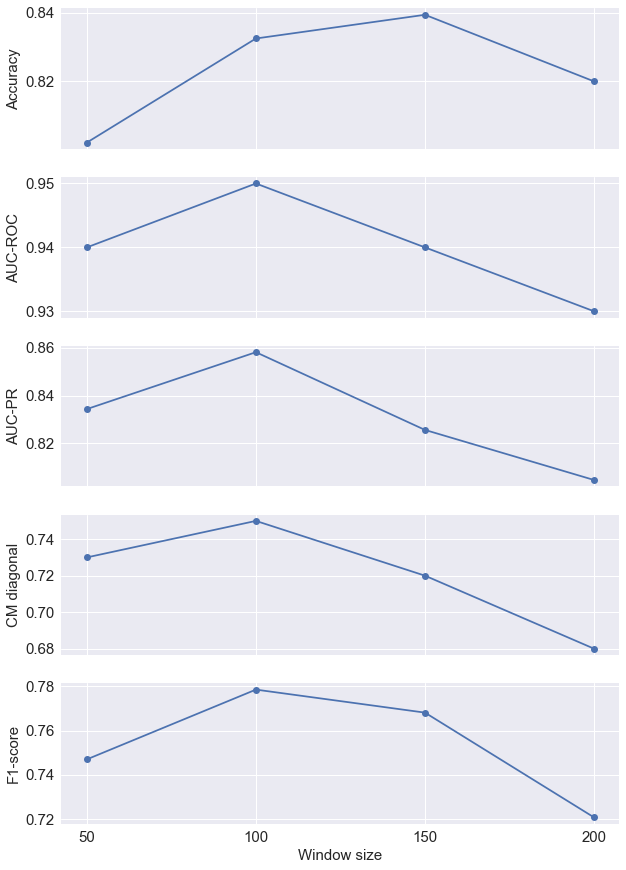

In [24]:
# MIREMOS LOS RESULTADOS

fig, axes = plt.subplots(5,sharex=True,figsize=(10,15))
axes[0].plot(Window_size,ACC,'o-')
axes[0].set_ylabel('Accuracy',fontsize=15)

axes[1].plot(Window_size,AUC_ROC,'o-')
axes[1].set_ylabel('AUC-ROC',fontsize=15)

axes[2].plot(Window_size,AUC_PR,'o-')
axes[2].set_ylabel('AUC-PR',fontsize=15)

axes[3].plot(Window_size,CM_diag,'o-')
axes[3].set_ylabel('CM diagonal',fontsize=15)

axes[4].plot(Window_size,F1,'o-')
axes[4].set_ylabel('F1-score',fontsize=15)

for ax in axes:
    ax.tick_params(axis='y',labelsize=15)

plt.xticks(np.array(Window_size),fontsize=15)
plt.xlabel('Window size',fontsize=15)
plt.show()

#### Ahora tendríamos que hacer una optimización de:

1) La representación de los datos: tamaño de la ventana, número de features.

2) Hiperparámetros del modelo (número de árboles, max-features por arbol, profundidad...)

Pero dejémoslo para más tarde. Veamos cómo se comporta el modelo en el test set definido con sliding windows.

In [25]:
# Elijamos un set de parametros y testeemos en los sujetos del Test Set

# Primero entrenamos en todo el Training set
w=90
data,target= matCorr_non_overlapping(time_series_df,hypnograms_df,Train_subjects,w)

num_trees=200 #number of trees in the random forest algorithm
percentile = 10 # this defines the percentile of features that we are going to use in the classification (top percentile%)

X_train=data
y_train=target

print('Start training')
start_time=time.time()
selector = SelectPercentile(f_classif, percentile=percentile) # apply feature selection (F-test) on the training data
selector.fit(X_train, y_train)
X_train_fs = selector.transform(X_train)

clf = RandomForestClassifier(n_estimators=num_trees) # create, train and predict the scores for the features in the test set
clf = clf.fit(X_train_fs, y_train)
end_time=time.time()
print('Elapsed time:',np.around(end_time-start_time,decimals=2),'seg')




Calculando matrices de correlacion
Elapsed time: 2.19  seg
Start training
Elapsed time: 1.0 seg


In [27]:
# Construimos el Test set

Test_data=matCorr_sliding(time_series_df,hypnograms_df,Test_subjects,w=60)

target_probas=Test_data['sleep_stage_prob']
target=Test_data['sleep_stage']
X_test=Test_data['matCorr']



Computando matrices de correlacion en sliding windows. Esto puede llevar algunos minutos.
Elapsed time: 42.8  seg


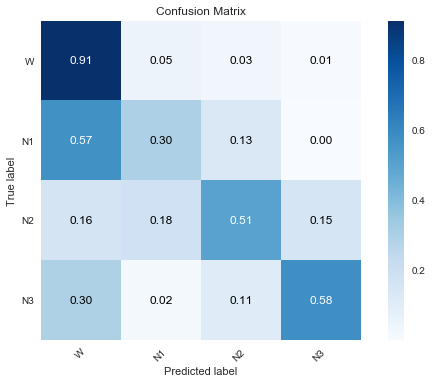

In [28]:
# PREDICT ON THE TEST SET

X_test_fs=selector.transform(X_test)
preds = clf.predict(X_test_fs)
pred_probas = clf.predict_proba(X_test_fs)
        
plot_confusion_matrix(target , preds, classes=np.array(['W','N1','N2','N3']),title='Confusion Matrix',normalize=True)
plt.show()       

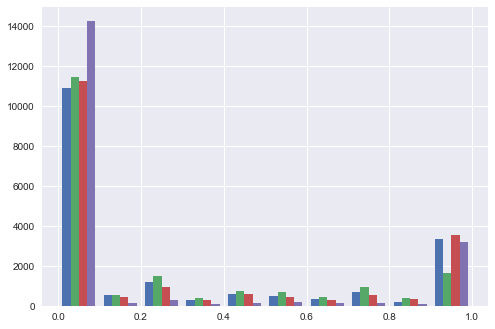

In [29]:
# Composicion del test set: cuántos de nuestros datos contienen estados mixtos (agarran las transiciones entre sueño y vigilia)

plt.hist(target_probas)
plt.show()


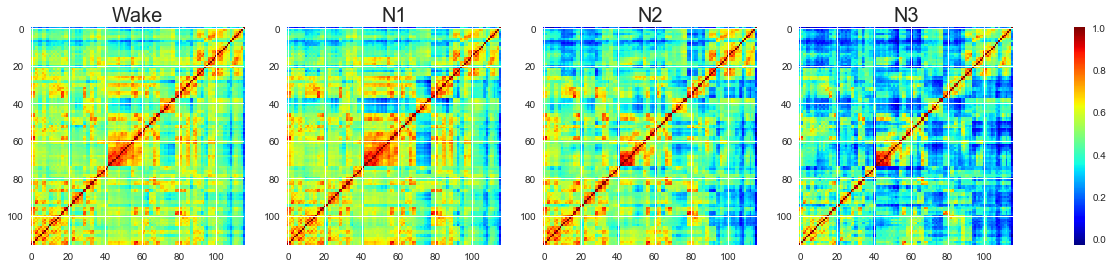

In [30]:
min_corr=np.min([np.min(C_W),np.min(C_N1),np.min(C_N2),np.min(C_N3)]) # Ploteamos las matrices en la misma escala
f, axs = plt.subplots(1, 4,figsize=(22,4))
axs[0].imshow(np.flipud(C_W),cmap='jet',interpolation='none' ,aspect="auto",clim=(min_corr,1))
axs[0].set_title('Wake',fontsize=20)

axs[1].imshow(np.flipud(C_N1),cmap='jet',interpolation='none',aspect="auto",clim=(min_corr,1))
axs[1].set_title('N1',fontsize=20)

axs[2].imshow(np.flipud(C_N2),cmap='jet',interpolation='none',aspect="auto",clim=(min_corr,1))
axs[2].set_title('N2',fontsize=20)

im=axs[3].imshow(np.flipud(C_N3),cmap='jet',interpolation='none',aspect="auto",clim=(min_corr,1))
axs[3].set_title('N3',fontsize=20)
f.colorbar(im, ax=axs.ravel().tolist())
plt.show()

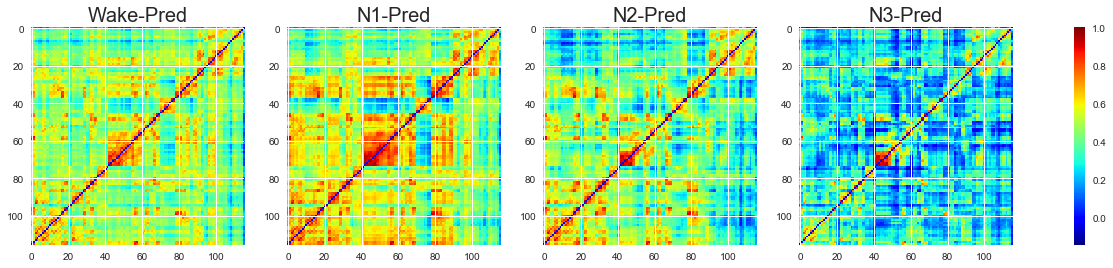

In [31]:

# Matrices de conectividad funcional representativas de los estados predichos

CW=np.zeros(X_test.shape[1])
CN1=np.zeros(X_test.shape[1])
CN2=np.zeros(X_test.shape[1])
CN3=np.zeros(X_test.shape[1])

nW=0
nN1=0
nN2=0
nN3=0

for i in range(target_probas.shape[0]):    
    state=np.argmax(pred_probas[i,:])         
    if state==0:
        nW+=1
        CW+=X_test[i,:]
    if state==1:
        nN1+=1
        CN1+=X_test[i,:]
    if state==2:
        nN2+=1
        CN2+=X_test[i,:]
    if state==3:
        nN3+=1
        CN3+=X_test[i,:]        
        
CW=squareform(CW/nW)
CN1=squareform(CN1/nN1)
CN2=squareform(CN2/nN2)
CN3=squareform(CN3/nN3)
        
    
min_corr=np.min([np.min(CW),np.min(CN1),np.min(CN2),np.min(CN3)]) # Ploteamos las matrices en la misma escala
f, axs = plt.subplots(1, 4,figsize=(22,4))
axs[0].imshow(np.flipud(CW),cmap='jet',interpolation='none' ,aspect="auto",clim=(min_corr,1))
axs[0].set_title('Wake-Pred',fontsize=20)

axs[1].imshow(np.flipud(CN1),cmap='jet',interpolation='none',aspect="auto",clim=(min_corr,1))
axs[1].set_title('N1-Pred',fontsize=20)

axs[2].imshow(np.flipud(CN2),cmap='jet',interpolation='none',aspect="auto",clim=(min_corr,1))
axs[2].set_title('N2-Pred',fontsize=20)

im=axs[3].imshow(np.flipud(CN3),cmap='jet',interpolation='none',aspect="auto",clim=(min_corr,1))
axs[3].set_title('N3-Pred',fontsize=20)
f.colorbar(im, ax=axs.ravel().tolist())
plt.show()    
    

# ELIJAN SU PROPIA AVENTURA


### Algunos posibles desafíos:

#### 1) Mejorar el clasificador

Hacer una exploración de parámetros más detallada para mejorar el clasificador. Esto va desde elegir la ventana temporal óptima y el porcentaje de features que conservamos durante el entrenamiento, hasta hacer un fine-tuning de los hiperparámentros del modelo (número de árboles, profundidad, distribución de features, etc).

¿Convendrá entrenar el clasificador con un subset de datos balanceado entre clases?

De todas las herramientas que aprendieron en el curso, se les ocurre alguna especialmente promisoria para mejorar la performance del algoritmo? Tal vez Xgboost, o entrenar directamente algún otro clasificador que conozcan a ver si supera al random forest...

#### 2) Concentrar nuestra atención en separar mejor W-N1

El clasificador que construimos (una vez que lo optimicemos) va a estar buenísimo, pero tiene un problema fundamental: su mayor debilidad está en separar correctamente el estado de vigilia del N1. Esto es especialmente sensible, porque es muy probable que en los experimentos de Resting State en algún momento los sujetos pasen por la fase N1 de sueño, pero no alcancen fases de sueño más profundas. 

¿Cómo reformularían el problema si nuestro objetivo principal no fuera la identificación correcta de cada fase de sueño, sino simplemente identificar sujetos que en algún momento se quedaron dormidos? Para esto tenemos un dataset de sujetos que nunca se durmieron.

#### 3) Construir un clasificador no supervisado

Todo lo que hicimos hasta ahora corresponde al mundo de aprendizaje supervisado: es decir que fue posible entrenar al clasificador gracias a que teníamos las etiquetas correctas provistas por los hipnogramas. Eso está genial, pero obtener dichas etiquetas fue muy costoso! Por un lado fue necesario tomar mediciones de EEG en simultaneo con fMRI, lo cual presenta desafíos experimentales no triviales. Además, los hipnogramas que usamos fueron construidos mirando A OJO las señales de EEG por una noble alma a quien le debemos nuestra pleitesía. Por estos motivos es que la enorme mayoría de estudios de Resting-State fMRI no incluyen ningún control sobre si los sujetos se quedaron dormidos o no, más que preguntárselo a los propios sujetos al final del experimento.

Para saber si los sujetos se durmieron en un experimento sin co-registros de EEG, un posible camino sería usar el clasificador que entrenamos con nuestros datos. Pero un problema de esto es que los protocolos de medición cambian en cada estudio: se usan diferentes resonadores configurando sus parámetros de manera tal que se resalten diferentes aspectos en las imagenes y esto podría alterar la performance del clasificador.

Otro camino interesante sería construir un clasificador no supervisado.

¿Cómo constuirían un clasificador usando sólamente los datos de fMRI? (Pueden usar la información de los hipnogramas para evaluar, pero no para entrenar!)


### Envíenme sus resultados/sugerencias a ariel.haimovici@gmail.com 


